# Construct a custom Environment for Pair Trading

Some examples on the market
* [custom env example](https://colab.research.google.com/github/araffin/rl-tutorial-jnrr19/blob/sb3/5_custom_gym_env.ipynb#scrollTo=RqxatIwPOXe_)
* [StockTradingEnv by Adam King](https://github.com/notadamking/Stock-Trading-Environment)
* [FinRL](https://github.com/AI4Finance-Foundation/FinRL)

Target is to construct a custom Env for pair trading

This env restrict the behaviour of RL learner to pair trading only

## Import the Custom Trading Env

In [1]:
import os
import csv
import pickle
import pandas as pd
import quantstats as qs
import matplotlib.pyplot as plt
from tqdm import trange
from stable_baselines3 import PPO, A2C, DDPG

from params import *
from utils.read2df import read2df, unify_dfs
from utils.clearlogs import clear_logs
from utils.rlmetrics import get_return, get_metrics
from envs.env_rl_restrict_thres import RL_RestrictFreeAmt_TradeEnv

folder_path = f"result/rl-restrict-thres-freeamt"
os.makedirs(folder_path, exist_ok=True)

## Prepare Trading Data
Load data from `preliminaries.ipynb`

In [2]:
with open('result/cointncorr.pickle', 'rb') as pk:
    cointncorr = pickle.load(pk)

with open('result/gridsearch/best_res.pickle', 'rb') as pk:
    best_profit, best_params = pickle.load(pk)

dfs = read2df(symbols=cointncorr[0], freqs={cointncorr[1]: freqs[cointncorr[1]]}, marketType='spot')
tics, df = unify_dfs(dfs, symbols=cointncorr[0], period=best_params['period'])

In [3]:
df.tail(10)

,time,close0,itvl,datetime,close1,spread,zscore
521369,1703818259999,0.000026,1m,2023-12-29 02:50:59.999,0.000028,-0.000002,0.083267
521370,1703818319999,0.000026,1m,2023-12-29 02:51:59.999,0.000028,-0.000002,0.082584
521371,1703818379999,0.000026,1m,2023-12-29 02:52:59.999,0.000028,-0.000002,0.063342
521372,1703818439999,0.000026,1m,2023-12-29 02:53:59.999,0.000028,-0.000002,0.088554
521373,1703818499999,0.000026,1m,2023-12-29 02:54:59.999,0.000028,-0.000002,0.086473
521374,1703818559999,0.000026,1m,2023-12-29 02:55:59.999,0.000028,-0.000002,0.224487
521375,1703818619999,0.000026,1m,2023-12-29 02:56:59.999,0.000028,-0.000002,0.257121
521376,1703818679999,0.000026,1m,2023-12-29 02:57:59.999,0.000028,-0.000002,0.291488
521377,1703818739999,0.000026,1m,2023-12-29 02:58:59.999,0.000028,-0.000002,0.536032
521378,1703818799999,0.000026,1m,2023-12-29 02:59:59.999,0.000028,-0.000002,1.049747


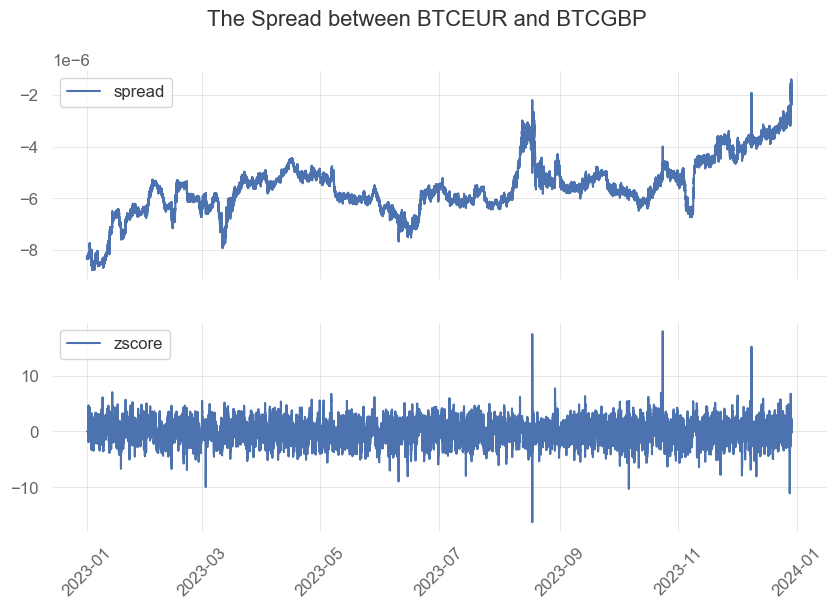

In [4]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

ax1.plot(df['datetime'], df['spread'], label='spread')
ax2.plot(df['datetime'], df['zscore'], label='zscore')

ax1.legend()
ax2.legend()
plt.suptitle(f'The Spread between {cointncorr[0][0]} and {cointncorr[0][1]}')

plt.xticks(rotation=45)
plt.show()

In [5]:
train = df[(df['datetime'] >= datetime.strptime(start_date, date_format)) & (df['datetime'] < datetime.strptime(trade_date, date_format))]
test = df[(df['datetime'] >= datetime.strptime(trade_date, date_format)) & (df['datetime'] < datetime.strptime(end_date, date_format))]

max_train_len = int((len(train)-best_params['period'])*0.95)
print(f"The length of our training data: {len(train)}")

The length of our training data: 87840


## Check with baselin3 `env_checker`

Check if the env meets the requirements of `stable_baseline3`

In [6]:
from stable_baselines3.common.env_checker import check_env

env = RL_RestrictFreeAmt_TradeEnv(train)
check_env(env)

c:\Users\hyan212\Miniconda3\envs\btrl\lib\site-packages\stable_baselines3\common\env_checker.py:452: UserWarning: Your action space has dtype float64, we recommend using np.float32 to avoid cast errors.
  warnings.warn(


In [7]:
test_env_expt = RL_RestrictFreeAmt_TradeEnv(test, model=f"{folder_path}/networth_expt.csv", verbose=1)

try:
    os.remove(f"{folder_path}/networth_expt.csv")
except OSError:
    pass

obs, _ = test_env_expt.reset()

for i in trange(20):
    obs, rewards, terminated, truncated, info = test_env_expt.step(action=env.action_space.sample())
    # test_env_expt.render()

test_env_expt.close()

100%|██████████| 20/20 [00:00<00:00, 157.81it/s]

Finished
networth: 0.9835238399979791


Tensorboard

## Train the Model with Trading Env

In [8]:
log_path = f"logs/restrict_thres_freeamt/"
clear_logs(log_path)

# Read more about tensorboard
# https://github.com/tensorflow/tensorboard/blob/master/README.md
# https://www.tensorflow.org/tensorboard/get_started

Deleted: logs/restrict_thres_freeamt/A2C_1
Deleted: logs/restrict_thres_freeamt/PPO_1


In [9]:
'''PPO'''

model_ppo = PPO("MultiInputPolicy", env, verbose=0, gamma=1, batch_size=256, tensorboard_log=log_path)
model_ppo.learn(total_timesteps=max_train_len, progress_bar=False)
model_ppo.save(f"{folder_path}/ppo_pairtrading")

In [10]:
'''A2C'''

model_a2c = A2C("MultiInputPolicy", env, verbose=0, gamma=1, tensorboard_log=log_path)
model_a2c.learn(total_timesteps=max_train_len, progress_bar=True)
model_a2c.save(f"{folder_path}/a2c_pairtrading")

Output()

In [11]:
# '''
# DDPG
# '''

# model_ddpg = DDPG("MultiInputPolicy", env, verbose=0, gamma=1, batch_size=256, tensorboard_log=log_path)
# model_ddpg.learn(total_timesteps=max_train_len*0.95, progress_bar=True)
# model_ddpg.save(f"{folder_path}/dqn_pairtrading")

## Create the Custom Test Env

In [12]:
test_env_ppo = RL_RestrictFreeAmt_TradeEnv(test, model=f"{folder_path}/networth_ppo.csv", verbose=1)
test_env_a2c = RL_RestrictFreeAmt_TradeEnv(test, model=f"{folder_path}/networth_a2c.csv", verbose=1)
test_env_ddpg = RL_RestrictFreeAmt_TradeEnv(test, model=f"{folder_path}/networth_ddpg.csv", verbose=1)
test_env_expt = RL_RestrictFreeAmt_TradeEnv(test, model=f"{folder_path}/networth_expt.csv", verbose=1)

In [13]:
max_test_len = int(len(test) * 0.95)
print(f"The length of our test data: {max_test_len}")

The length of our test data: 38475


## Test Env with Trained Model

In [14]:
try:
    os.remove(f"{folder_path}/networth_ppo.csv")
except OSError:
    pass

obs, _ = test_env_ppo.reset()

for i in trange(max_test_len):
    action, _states = model_ppo.predict(obs)
    obs, rewards, terminated, truncated, info = test_env_ppo.step(action)
    if i%int(max_test_len/10)==0:
        test_env_ppo.render()

test_env_ppo.close()

  0%|          | 13/38475 [00:00<05:14, 122.23it/s]

signal: {'holdings': array([ 0., -0.], dtype=float32), 'zone': 1, 'zscore': array([0.9079923], dtype=float32)}, action: -1.0, reward:0.0, networth: 1.0


 10%|█         | 3864/38475 [00:56<04:41, 122.94it/s]

signal: {'holdings': array([-0.9915439,  0.9915439], dtype=float32), 'zone': 1, 'zscore': array([0.4867236], dtype=float32)}, action: -1.0, reward:1.0, networth: 0.3389


 20%|██        | 7712/38475 [01:26<04:29, 114.35it/s]

signal: {'holdings': array([-0.97855073,  0.97855073], dtype=float32), 'zone': 1, 'zscore': array([1.3618864], dtype=float32)}, action: -1.0, reward:1.0, networth: 0.1111


 30%|███       | 11562/38475 [01:57<03:32, 126.58it/s]

signal: {'holdings': array([ 0.81101483, -0.81101483], dtype=float32), 'zone': 2, 'zscore': array([-0.17013337], dtype=float32)}, action: 0.8324399590492249, reward:0.0, networth: 0.0338


 40%|████      | 15407/38475 [02:28<02:57, 130.25it/s]

signal: {'holdings': array([-0.40037373,  0.40037373], dtype=float32), 'zone': 1, 'zscore': array([0.60360646], dtype=float32)}, action: -1.0, reward:1.0, networth: 0.0093


 50%|█████     | 19258/38475 [02:58<02:57, 108.16it/s]

signal: {'holdings': array([-0.9619785,  0.9619785], dtype=float32), 'zone': 1, 'zscore': array([0.9135977], dtype=float32)}, action: -1.0, reward:1.0, networth: 0.0041


 60%|██████    | 23094/38475 [03:31<02:17, 111.91it/s]

signal: {'holdings': array([-0.9973574,  0.9973574], dtype=float32), 'zone': 1, 'zscore': array([0.58071077], dtype=float32)}, action: -1.0, reward:1.0, networth: 0.0016


 70%|███████   | 26944/38475 [04:03<01:34, 122.24it/s]

signal: {'holdings': array([ 0.98614436, -0.98614436], dtype=float32), 'zone': 2, 'zscore': array([0.11167536], dtype=float32)}, action: 0.7720620036125183, reward:0.0, networth: 0.0007


 80%|████████  | 30796/38475 [04:36<00:59, 130.01it/s]

signal: {'holdings': array([-0.9298891,  0.9298891], dtype=float32), 'zone': 1, 'zscore': array([1.4829485], dtype=float32)}, action: -1.0, reward:1.0, networth: 0.0003


 90%|█████████ | 34639/38475 [05:07<00:31, 120.13it/s]

signal: {'holdings': array([-0.10407274,  0.10407274], dtype=float32), 'zone': 2, 'zscore': array([-0.27726954], dtype=float32)}, action: 0.23215758800506592, reward:0.0, networth: 0.0001


100%|██████████| 38475/38475 [05:38<00:00, 113.55it/s]

signal: {'holdings': array([ 0.9963361, -0.9963361], dtype=float32), 'zone': 3, 'zscore': array([-1.438743], dtype=float32)}, action: 1.0, reward:1.0, networth: 0.0
Finished
networth: 3.528841070581004e-05


In [15]:
try:
    os.remove(f"{folder_path}/networth_a2c.csv")
except OSError:
    pass

obs, _ = test_env_a2c.reset()

for i in trange(max_test_len):
    action, _states = model_a2c.predict(obs)
    obs, rewards, terminated, truncated, info = test_env_a2c.step(action)
    if i%int(max_test_len/10)==0:
        test_env_a2c.render()

test_env_a2c.close()

  0%|          | 12/38475 [00:00<05:25, 118.11it/s]

signal: {'holdings': array([ 0., -0.], dtype=float32), 'zone': 1, 'zscore': array([0.9079923], dtype=float32)}, action: -1.0, reward:0.0, networth: 1.0


 10%|█         | 3863/38475 [00:52<05:00, 115.26it/s]

signal: {'holdings': array([-0.99806243,  0.99806243], dtype=float32), 'zone': 1, 'zscore': array([0.4867236], dtype=float32)}, action: -1.0, reward:1.0, networth: 1.0364


 20%|██        | 7719/38475 [01:26<04:09, 123.49it/s]

signal: {'holdings': array([-0.99939185,  0.99939185], dtype=float32), 'zone': 1, 'zscore': array([1.3618864], dtype=float32)}, action: -1.0, reward:1.0, networth: 1.0982


 30%|███       | 11562/38475 [01:58<03:37, 123.97it/s]

signal: {'holdings': array([ 0.9998872, -0.9998872], dtype=float32), 'zone': 2, 'zscore': array([-0.17013337], dtype=float32)}, action: 1.0, reward:0.0, networth: 1.1801


 40%|████      | 15405/38475 [02:31<03:19, 115.91it/s]

signal: {'holdings': array([ 0.9979301, -0.9979301], dtype=float32), 'zone': 1, 'zscore': array([0.60360646], dtype=float32)}, action: -1.0, reward:0.078, networth: 1.3189


 50%|█████     | 19256/38475 [03:05<02:55, 109.34it/s]

signal: {'holdings': array([-0.99924374,  0.99924374], dtype=float32), 'zone': 1, 'zscore': array([0.9135977], dtype=float32)}, action: -1.0, reward:1.0, networth: 1.5832


 60%|██████    | 23105/38475 [03:38<02:05, 122.74it/s]

signal: {'holdings': array([-0.99986756,  0.99986756], dtype=float32), 'zone': 1, 'zscore': array([0.58071077], dtype=float32)}, action: -1.0, reward:1.0, networth: 1.6698


 70%|███████   | 26948/38475 [04:11<01:47, 106.93it/s]

signal: {'holdings': array([ 0.9984672, -0.9984672], dtype=float32), 'zone': 2, 'zscore': array([0.11167536], dtype=float32)}, action: 0.7064031362533569, reward:0.0, networth: 2.0


 80%|████████  | 30794/38475 [04:46<01:04, 118.88it/s]

signal: {'holdings': array([-0.9992461,  0.9992461], dtype=float32), 'zone': 1, 'zscore': array([1.4829485], dtype=float32)}, action: -1.0, reward:1.0, networth: 2.5558


 90%|█████████ | 34637/38475 [05:21<00:39, 96.50it/s] 

signal: {'holdings': array([ 0.9930327, -0.9930327], dtype=float32), 'zone': 2, 'zscore': array([-0.27726954], dtype=float32)}, action: 1.0, reward:0.0, networth: 2.9947


100%|██████████| 38475/38475 [05:53<00:00, 108.90it/s]

signal: {'holdings': array([ 0.9991601, -0.9991601], dtype=float32), 'zone': 3, 'zscore': array([-1.438743], dtype=float32)}, action: 1.0, reward:1.0, networth: 3.6299
Finished
networth: 3.629871147065985


In [16]:
# try:
#     os.remove(f"{folder_path}/networth_ddpg.csv")
# except OSError:
#     pass

# obs, _ = test_env_ddpg.reset()

# for i in trange(max_test_len):
#     action, _states = model_ddpg.predict(obs)
#     obs, rewards, terminated, truncated, info = test_env_ddpg.step(action)
#     if i%int(max_test_len/10)==0:
#         test_env_ddpg.render()

# test_env_ddpg.close()

## Also run randomly generated actions

In [17]:
try:
    os.remove(f"{folder_path}/networth_expt.csv")
except OSError:
    pass

obs, _ = test_env_expt.reset()

for i in trange(max_test_len):
    obs, rewards, terminated, truncated, info = test_env_expt.step(action=env.action_space.sample())
    if i%int(max_test_len/10)==0:
        test_env_expt.render()

test_env_expt.close()

  0%|          | 15/38475 [00:00<04:33, 140.54it/s]

signal: {'holdings': array([ 0., -0.], dtype=float32), 'zone': 1, 'zscore': array([0.9079923], dtype=float32)}, action: -0.6989327432757482, reward:0.0, networth: 1.0


 10%|█         | 3864/38475 [00:46<04:00, 143.73it/s]

signal: {'holdings': array([ 0.22173925, -0.22173925], dtype=float32), 'zone': 1, 'zscore': array([0.4867236], dtype=float32)}, action: 0.4767671063276151, reward:0.0, networth: 0.0769


 20%|██        | 7718/38475 [01:10<03:09, 162.60it/s]

signal: {'holdings': array([ 0.2808779, -0.2808779], dtype=float32), 'zone': 1, 'zscore': array([1.3618864], dtype=float32)}, action: -0.5904741464573344, reward:0.0, networth: 0.0065


 30%|███       | 11568/38475 [01:33<02:44, 163.44it/s]

signal: {'holdings': array([ 0.28545186, -0.28545186], dtype=float32), 'zone': 2, 'zscore': array([-0.17013337], dtype=float32)}, action: -0.6065118798069629, reward:-0.0, networth: 0.0004


 40%|████      | 15414/38475 [01:57<02:18, 166.22it/s]

signal: {'holdings': array([ 0.8565095, -0.8565095], dtype=float32), 'zone': 1, 'zscore': array([0.60360646], dtype=float32)}, action: 0.47574438973568944, reward:0.0, networth: 0.0


 50%|█████     | 19261/38475 [02:23<02:03, 155.42it/s]

signal: {'holdings': array([-0.00061029,  0.00061029], dtype=float32), 'zone': 1, 'zscore': array([0.9135977], dtype=float32)}, action: -0.631588088853599, reward:1.0, networth: 0.0


 60%|██████    | 23106/38475 [02:48<01:47, 142.54it/s]

signal: {'holdings': array([-0.6426978,  0.6426978], dtype=float32), 'zone': 1, 'zscore': array([0.58071077], dtype=float32)}, action: 0.4424766935689577, reward:0.0, networth: 0.0


 70%|███████   | 26945/38475 [03:14<01:12, 158.60it/s]

signal: {'holdings': array([ 0.34771097, -0.34771097], dtype=float32), 'zone': 2, 'zscore': array([0.11167536], dtype=float32)}, action: -0.3743310050601574, reward:0.0, networth: 0.0


 80%|████████  | 30801/38475 [03:38<00:43, 176.58it/s]

signal: {'holdings': array([-0.9323732,  0.9323732], dtype=float32), 'zone': 1, 'zscore': array([1.4829485], dtype=float32)}, action: 0.3512290108589773, reward:0.0, networth: 0.0


 90%|█████████ | 34646/38475 [04:01<00:21, 181.33it/s]

signal: {'holdings': array([-0.28682566,  0.28682566], dtype=float32), 'zone': 2, 'zscore': array([-0.27726954], dtype=float32)}, action: 0.8343852158418825, reward:0.0, networth: 0.0


100%|██████████| 38475/38475 [04:23<00:00, 145.94it/s]

signal: {'holdings': array([ 0.18084437, -0.18084437], dtype=float32), 'zone': 3, 'zscore': array([-1.438743], dtype=float32)}, action: -0.14087296168182384, reward:-0.0, networth: 0.0
Finished
networth: 8.501033799647798e-12


### Analyze with Quanstats

In [18]:
os.remove(f"{folder_path}/networth_expt.csv") if os.path.exists(f"{folder_path}/networth_expt.csv") else None

csv_files = [file for file in os.listdir(folder_path) if file.endswith('.csv')]

best_res, best_model = None, None
for file_name in csv_files:
    file_path = os.path.join(folder_path, file_name)
    
    with open(file_path, 'r') as csv_file:
        csv_reader = csv.reader(csv_file)
        
        # Loop through the lines in the CSV file
        last_line = None
        for row in csv_reader:
            last_line = row  # Update last_line with the current row
    
    if best_res is None or float(best_res) < float(last_line[1]):
        best_res = last_line[1]
        best_model = file_name

    print(f"The ending capital of {file_name} is {last_line[0:2]}")

print(f"The best model is {best_model}")

The ending capital of networth_a2c.csv is ['2023-12-28 08:15:59.999000', '3.629871147065985']
The ending capital of networth_ppo.csv is ['2023-12-28 08:15:59.999000', '3.528841070581004e-05']
The best model is networth_a2c.csv


In [19]:
best_return = get_return(f'{folder_path}/{best_model}')
get_metrics(best_return)

Compound annual growth rate: 7334909558%
Total orders count: 38474
Total long action: 0
Total short action: 0
Won orders count: 3050
Lost orders count: 919
Win/Loss order ratio: 3.318824809575626
Max win: 0.023200465977845308
Max Loss: -0.08346138766522815
Avg order pnl: 6.835450296475503e-05
Avg order pnl won: 0.0017742398749733205
Avg order pnl lost: -0.0030267252139310587


In [20]:
best_return

,values,action,zscore,position,price0,price1,pnl,returns
datetime,,,,,,,,
2023-12-01 15:02:59.999,1.000000,-1.0,0.796502,[-1.0007731 1.0007731],0.000028,0.000032,0.0,0.0
2023-12-01 15:03:59.999,1.000000,-1.0,0.927468,[-0.99968714 0.99968714],0.000028,0.000032,0.0,0.0
2023-12-01 15:04:59.999,1.000000,-1.0,0.979107,[-0.99952704 0.99952704],0.000028,0.000032,0.0,0.0
2023-12-01 15:05:59.999,1.000000,-1.0,0.925928,[-0.999141 0.999141],0.000028,0.000032,0.0,0.0
2023-12-01 15:06:59.999,1.000000,-1.0,0.975951,[-1.0008103 1.0008103],0.000028,0.000032,0.0,0.0
...,...,...,...,...,...,...,...,...
2023-12-28 08:11:59.999,3.629871,1.0,-1.625097,[ 0.99707323 -0.99707323],0.000026,0.000029,0.0,0.0
2023-12-28 08:12:59.999,3.629871,1.0,-1.587612,[ 0.99851924 -0.99851924],0.000026,0.000029,0.0,0.0
2023-12-28 08:13:59.999,3.629871,1.0,-1.892647,[ 0.99793845 -0.99793845],0.000026,0.000029,0.0,0.0


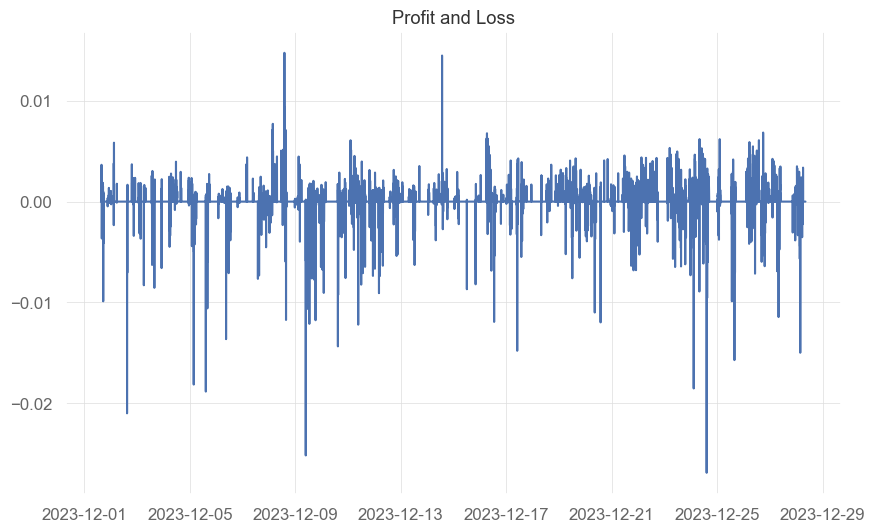

In [21]:
fig, ax = plt.subplots()

ax.set_title("Profit and Loss")
ax.plot(best_return['returns'])

plt.show()

                           Strategy
-------------------------  ------------
Start Period               2023-12-01
End Period                 2023-12-28
Risk-Free Rate             0.0%
Time in Market             11.0%

Cumulative Return          262.99%
CAGR﹪                     26707684.88%

Sharpe                     0.82
Prob. Sharpe Ratio         100.0%
Smart Sharpe               0.8
Sortino                    1.03
Smart Sortino              1.0
Sortino/√2                 0.73
Smart Sortino/√2           0.71
Omega                      1.88

Max Drawdown               -8.56%
Longest DD Days            4
Volatility (ann.)          1.04%
Calmar                     3118405.92
Skew                       -9.68
Kurtosis                   324.04

Expected Daily %           0.0%
Expected Monthly %         262.99%
Expected Yearly %          262.99%
Kelly Criterion            36.04%
Risk of Ruin               0.0%
Daily Value-at-Risk        -0.1%
Expected Shortfall (cVaR)  -0.1%

Max Consecuti

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2023-12-09,2023-12-10,2023-12-11,2,-8.564531,-8.349364
2,2023-12-05,2023-12-05,2023-12-08,4,-4.841666,-4.819920
3,2023-12-24,2023-12-24,2023-12-26,2,-4.416120,-4.231660
4,2023-12-02,2023-12-02,2023-12-03,1,-2.754630,-2.482094
5,2023-12-11,2023-12-12,2023-12-12,1,-2.741444,-2.702048


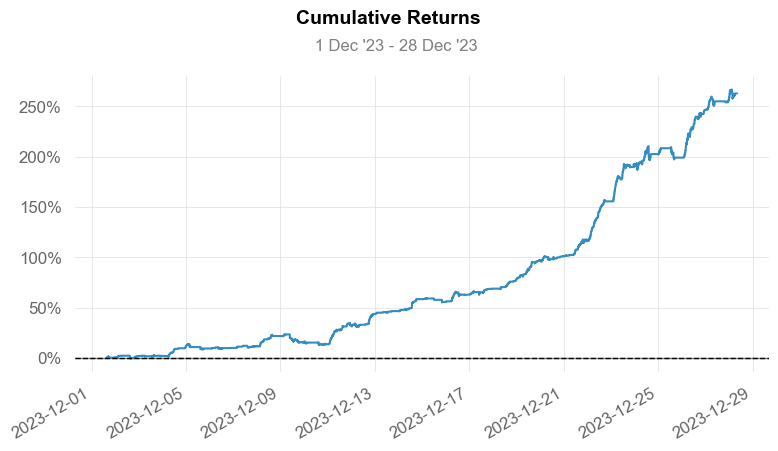

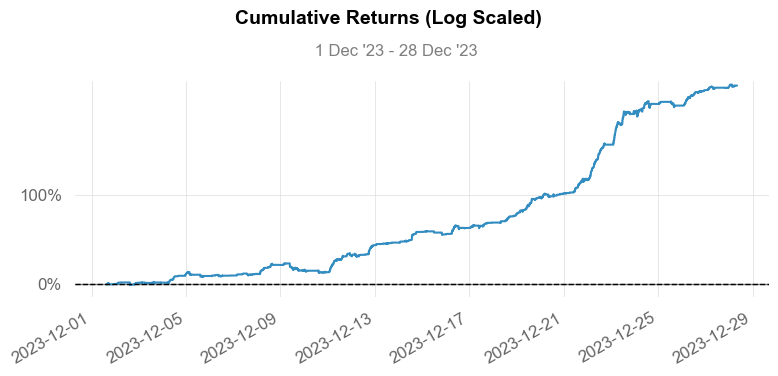

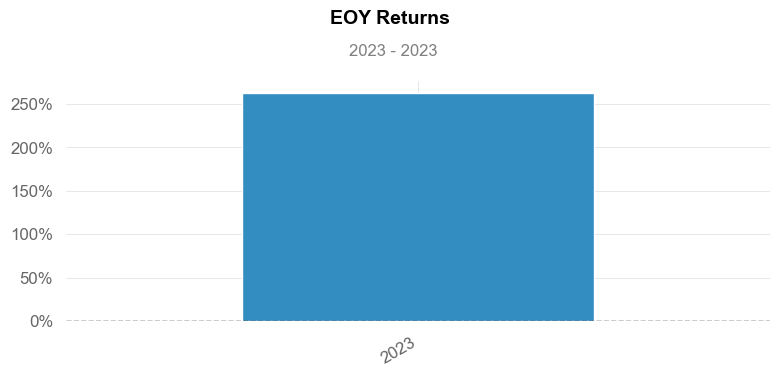

c:\Users\hyan212\Miniconda3\envs\btrl\lib\site-packages\quantstats\_plotting\core.py:516: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  _sns.kdeplot(data=combined_returns, color="black", ax=ax)


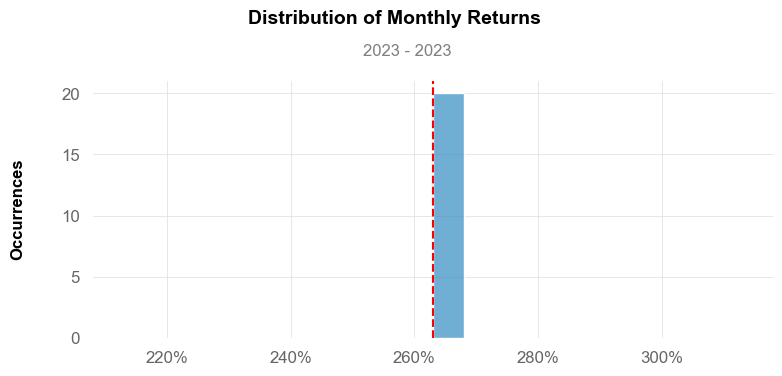

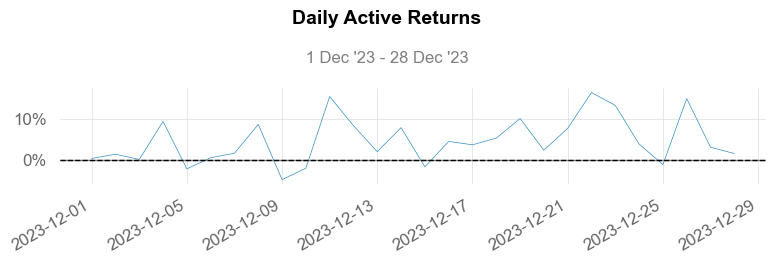

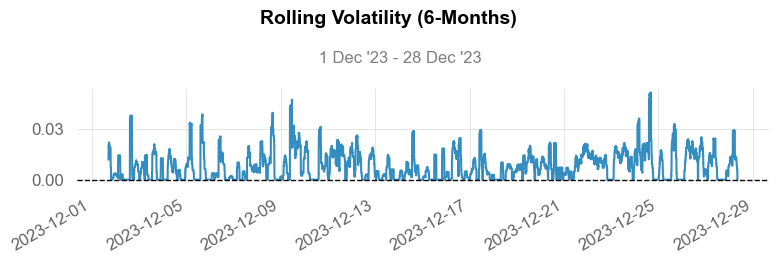

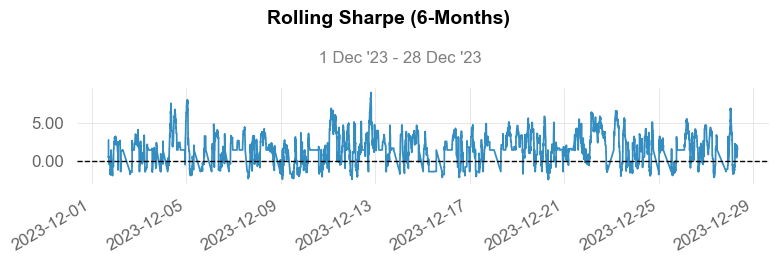

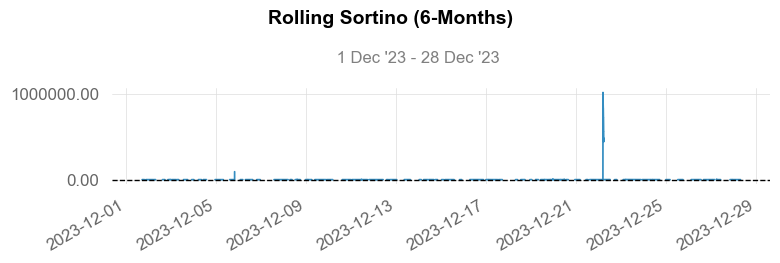

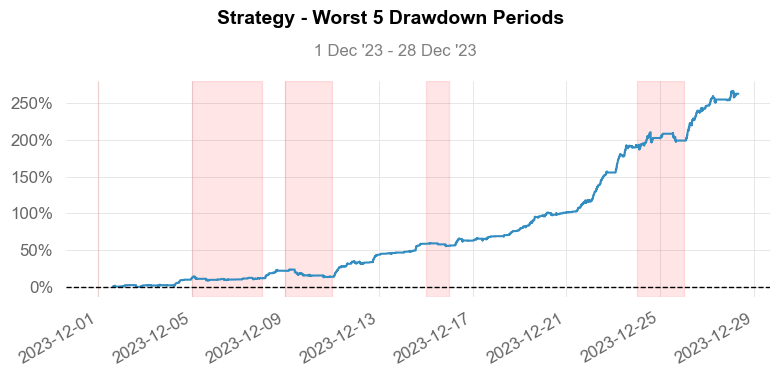

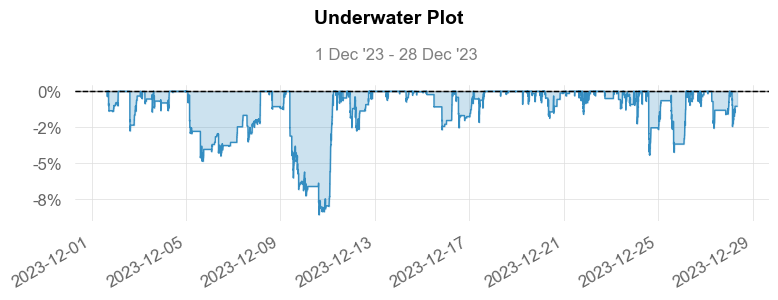

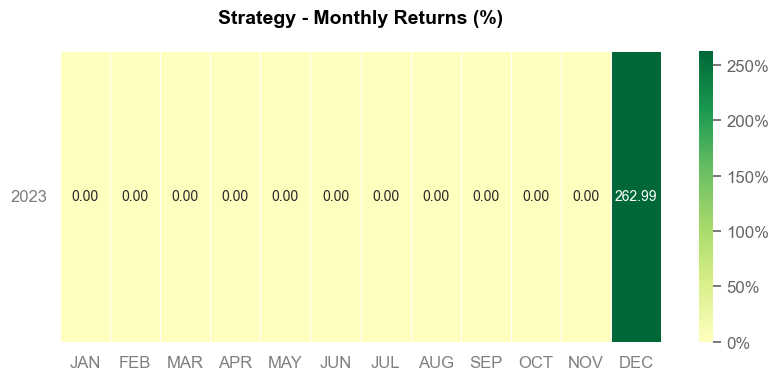

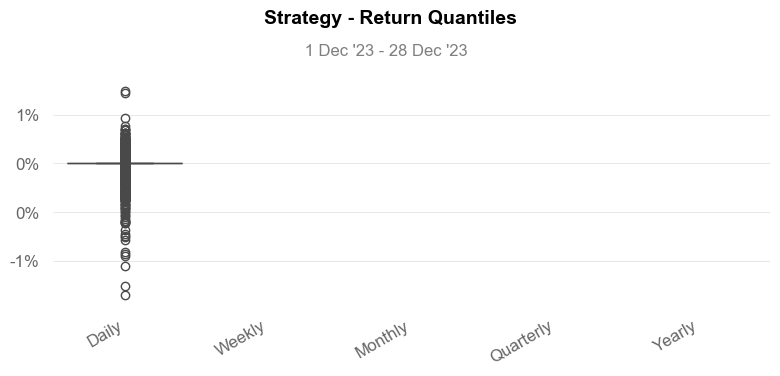

In [22]:
qs.reports.full(best_return['returns'])